<h1>Introduction</h1>
<p>
The sinking of the titanic occurred on the night of 14<sup>th</sup> April, 1912. It was the largest passenger liner in service at the time and had an estimated 2224 people on board when she had struck an iceberg around 2340 hours. Within hours, the ship was underwater. The accident resulted in the deaths of more than 1,500 people. The disaster caused widespread outrage over the lack of lifeboats, lax regulations, and the unequal treatment of the three passenger classes during the evacuation. 
</p>
<h2>Objectives</h2>
<p>
To analyze the survivability rate based on the data provided and extrapolate other unexpected reasons for survival.
</p>

<h2>Data Wrangling</h2>

<h3>Data description</h3>
<div id="description">
(from https://www.kaggle.com/c/titanic)
    <p>
      <ul>
        <li>survival: Survival (0 = No; 1 = Yes)</li>
        <li>pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)</li>
        <li>name: Name</li>
        <li>sex: Gender</li>
        <li>age: Age</li>
        <li>sibsp: Number of Siblings/Spouses Aboard</li>
        <li>parch: Number of Parents/Children Aboard</li>
        <li>ticket: Ticket Number</li>
        <li>fare: Passenger Fare</li>
        <li>cabin: Cabin</li>
        <li>embarked: Port of Departure (C = Cherbourg; Q = Queenstown; S = Southampton)</li>
      </ul>
    </p>

<h3>Notes:</h3>
    <p>
        <ul>
            <li>Pclass was used to denote socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower</li>
            <li>Age is in Years; Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5</li>
        </ul>
    </p>
    <p>
    With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored. The following are the definitions used for sibsp and parch.
    </p>
    <p>
        <ul>
            <li>Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic </li>
            <li>Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored) </li>
            <li>Parent: Mother or Father of Passenger Aboard Titanic </li>
            <li>Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic </li>
        </ul>
    </p>
    <p>
    Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them. As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.
    </p>
</div>
<h2>Initial questions</h2>
<p>
    <ol>
        <li>What factors are positively related to survival?</li>
        <li>Are there other factors that could affect survival?</li>
    </ol>
</p>

In [1]:
# Importing numpy, pandas for sorting data into matrices and matplot and seaborn libraries for visualization; 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# present charts inline 
%pylab inline

# setting style and background for all graphs
sns.set(color_codes=True)
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Helper functions:

# takes in target dataframe and plots correlation as heatmap
def plot_correlation_map( df ):
    corr = df.corr() # describes data in dataframe and stored in variable 
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True ) # color of tiles
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 } 
    )

# plots histogram of given dataframe; cat: data used for x-axis and target: data used for y-axis.
# row and col can take arguments and display individual graphs based on argument vertically or horizontally respectively.
def plot_categories( df, cat, target, **kwargs ):
    row = kwargs.get( 'row', None )
    col = kwargs.get( 'col', None )
    facet = sns.FacetGrid( df, row = row, col = col) # sets up grid
    facet.map( sns.barplot, cat, target) # displays bar graph
    facet.add_legend()

# plots histograms that displays the count of variable 1, with respect to the other variables and dataframe of interest
# all variables need to be strings
def graph_count_plotter (df, var1, var2, var3, **kwargs):
    return sns.factorplot( \
    var1, col=var2, hue=var3, data=df, kind='count', size=7, aspect=.8)

# plots kdeplot based on dataframe and variables. Different way of displaying data.
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True ) # displays continuous plot 
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
# loading titanic data as pandas dataframe
titanic_df = pd.read_csv('titanic_data.csv')

# data preview of full dataset
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some values for <b>Age</b> are NaN, while ticket and <b>Cabin</b> values are alphanumeric and were also missing some values. 


<h1>Data Cleaning</h1>

In [4]:
# determine number of missing values in cleaned data set
total_null = titanic_df.isnull().sum()
print total_null

# determining number of missing age entries for males and females

age_nans = pd.isnull(titanic_df['Age'])
cabin_nulls = pd.isnull(titanic_df['Cabin'])

print titanic_df[age_nans].head()

missing_age_female = titanic_df[age_nans]['Sex'] == 'female'
missing_age_male = titanic_df[age_nans]['Sex'] == 'male'
missing_cabin_female = titanic_df[cabin_nulls]['Sex'] == 'female'
missing_cabin_male = titanic_df[cabin_nulls]['Sex'] == 'male'
print "--------------"
print 'Number for females and males with age missing are {} and {} respectively \n\
Number of missing cabin numbers for female passengers: {} and male passengers: {}' .format(
    missing_age_female.sum(),missing_age_male.sum(),missing_cabin_male.sum(),missing_cabin_female.sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
    PassengerId  Survived  Pclass                           Name     Sex  Age  \
5             6         0       3               Moran, Mr. James    male  NaN   
17           18         1       2   Williams, Mr. Charles Eugene    male  NaN   
19           20         1       3        Masselmani, Mrs. Fatima  female  NaN   
26           27         0       3        Emir, Mr. Farred Chehab    male  NaN   
28           29         1       3  O'Dwyer, Miss. Ellen "Nellie"  female  NaN   

    SibSp  Parch  Ticket     Fare Cabin Embarked  
5       0      0  330877   8.4583   NaN        Q  
17      0      0  244373  13.0000   NaN        S  
19      0      0    2649   7.2250   NaN        C  
26      0      0    2631   7.2250   NaN        C  
28      0      0 

<p>It is to be noted that 177 null age items and 687 null cabin items were detected in the given dataset, which accounts for ~20% and ~77% of the total number of passengers respectively. The null embarked items are negligible as they account for 0.002% of the whole dataset and will not have significant consequences in our analysis. The null age values will not affect the graphing and summation operations on the data as it is treated as a zero(0) value, but it needs to be considered while reviewing descriptive stats like average (mean) age. </p>
<p> 
<b>Note:</b>
<br>
Number of female passengers whose age is missing - <b>124</b>
<br>
Number of male passengers whose age is missing - <b>53</b>
</p>

<p>The null values were replaced with median of the age rather than the mean or zero so that during the calculation of the mean so as to avoid any skewed values. 
</p>

In [5]:
# Cleaning data: Removing items that do not contribute to survival analysis

# Dropping information that does not pertain to current questions
# cleaned data will contain int variables and are chosen to make it easier to describe data.

titanic_cleaned = titanic_df.drop(['Cabin','Name','Ticket','PassengerId','Embarked'], axis=1)

# replacing Nans
median_age = titanic_cleaned['Age'].median()

# print median_age

titanic_without_nan = titanic_cleaned.fillna(median_age)

age_nans = pd.isnull(titanic_without_nan['Age'])
titanic_without_nan[age_nans].head() # checking if data-frame has any null values.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare


<p>Dataframe has been scrubbed for null values and were replaced median age.</p>

In [6]:
titanic_without_nan.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


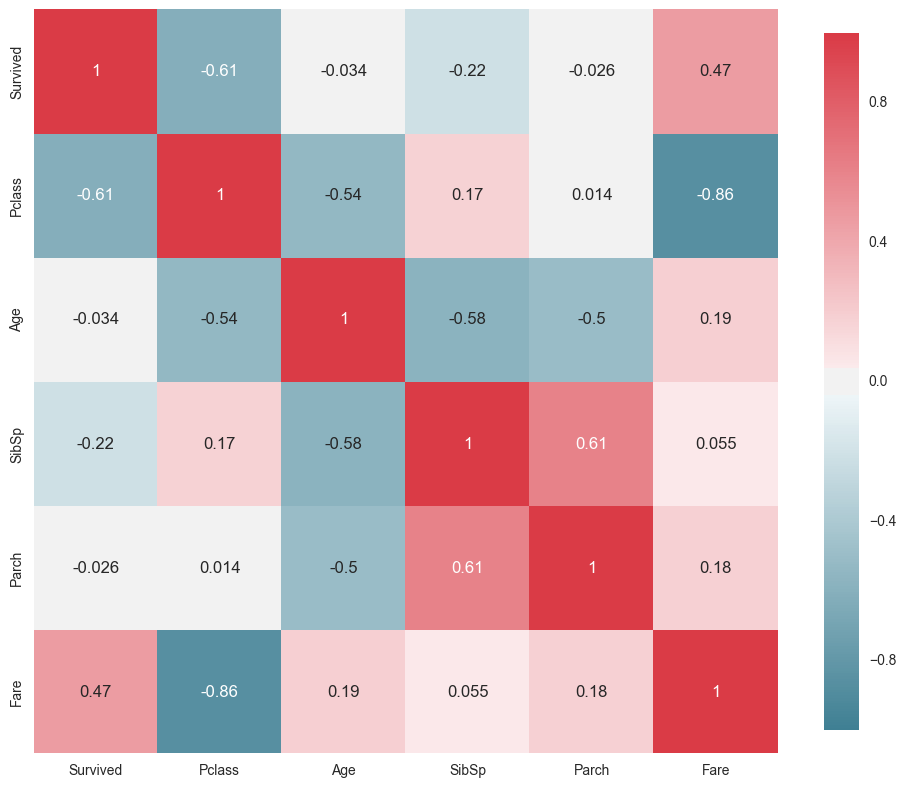

In [7]:
# correlation heatmap
correlated_variables = titanic_without_nan.corr()
plot_correlation_map(correlated_variables)

# heatmap shows important variables for consideration. 
# based on plot, positive correlation between survival and fare, 
# and negative correlation between survival and class. 

Let's investigate the correlation between the several variables presented in the dataset. The heatmap in the cell above shows positive correlation between survivability and age, whereas there is a negative correlation between class and survival. Initial observations suggest that we should investigate the following :
<h2>Questions</h2>
<p>
Q1. Are there any biases based on gender and class in the survivability of the passenger ? <br>
Q2. Was there increased survivability based on age? <br>
Q3. Does a family or individual have a higher chance to survive this catastrophe? 
</p>
<p>
Other questions that could be derived from this analysis: <br>
Q4. Was there any relation between the survivors and location from where the travellers originated (embarked)? <br>
</p>
Q5. Is there any relationship with lifeboat and cabin location? And is there increased chances of survival due to that?

In [8]:
# prints survival percentage values based on gender and class. It takes in dataframe(df) and 2 variables that defines
# how the df will be grouped and will perform calculations appropriately.

def percent_survivors( df , var1 , var2 ):
    n = 0
    sex = ['male','female']
    pclass = [1,2,3]
    df_survived = df[df['Survived']==True]
    for item in pclass:
        for gender in sex:
            grouped_class_gender = df.groupby([var1,var2]).size()[item,gender].astype('float') 
            survived_class_gender = df_survived.groupby([var1,var2]).size()[item,gender].astype('float')
            survivors_by_gender = ((survived_class_gender/grouped_class_gender) * 100).round(2)
            print "Survivors of {}: {} and {}: {} are {}%".format(var1,item,var2,gender,survivors_by_gender)
# percent_survivors (titanic_without_nan,'Pclass','Sex')
# print percent_survivors(titanic_without_nan, 1 , 'male')

Total number of survivors based on class and sex: 
Pclass  Sex     Survived
1       female  0             3.0
                1            91.0
        male    0            77.0
                1            45.0
2       female  0             6.0
                1            70.0
        male    0            91.0
                1            17.0
3       female  0            72.0
                1            72.0
        male    0           300.0
                1            47.0
dtype: float64


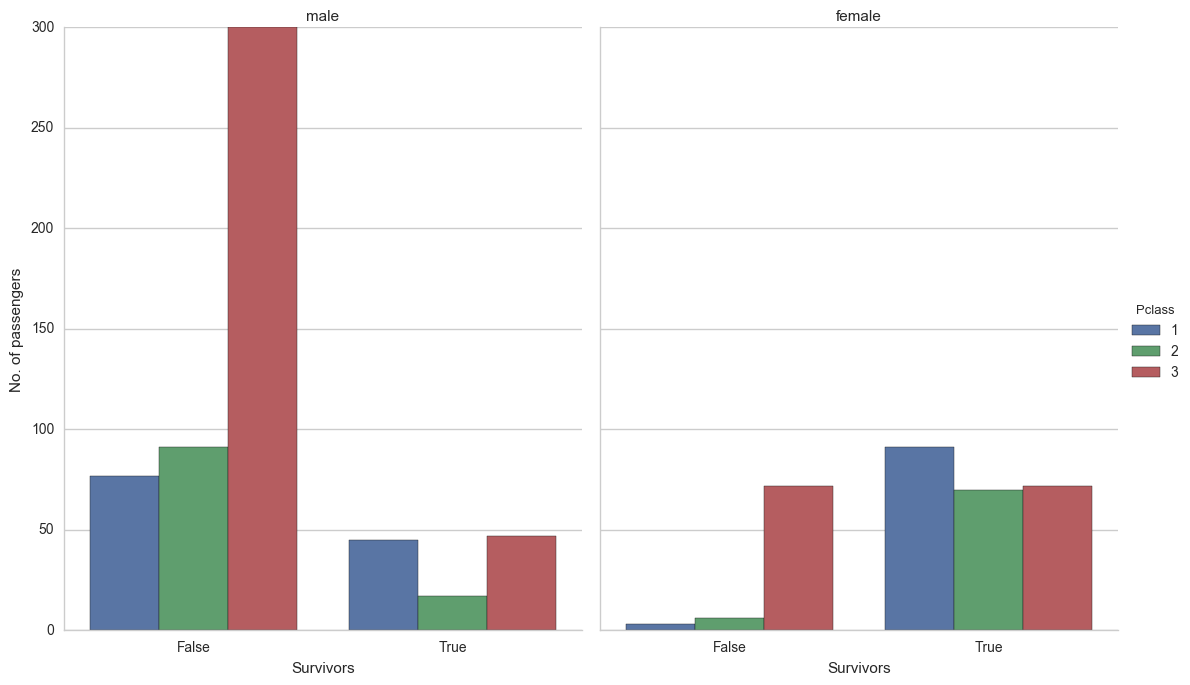

In [9]:
survived_class_gender = titanic_without_nan.groupby(['Pclass','Sex','Survived']).size().astype('float')

print "Total number of survivors based on class and sex: \n{}".format(survived_class_gender)

# Investiage total number of survivors based on class

g = graph_count_plotter(titanic_without_nan,'Survived','Sex','Pclass')

(g.set_axis_labels('Survivors','No. of passengers')
    .set_xticklabels(['False','True'])
    .set_titles('{col_name}')
)

<p>Based on the raw numbers it would appear as though passengers in Class 3 category had a similar survival rate as those from Class 1 category with 119 and 136 passengers surviving respectively. However, if we look closely at the percentages of the overall passengers per class and the total numbers across each class, it can be assumed that a passenger from Class 1 is about <b>2.5x</b> times more likely to survive than a passenger in Class 3.</p>

Survivors of Pclass: 1 and Sex: male are 36.89%
Survivors of Pclass: 1 and Sex: female are 96.81%
Survivors of Pclass: 2 and Sex: male are 15.74%
Survivors of Pclass: 2 and Sex: female are 92.11%
Survivors of Pclass: 3 and Sex: male are 13.54%
Survivors of Pclass: 3 and Sex: female are 50.0%


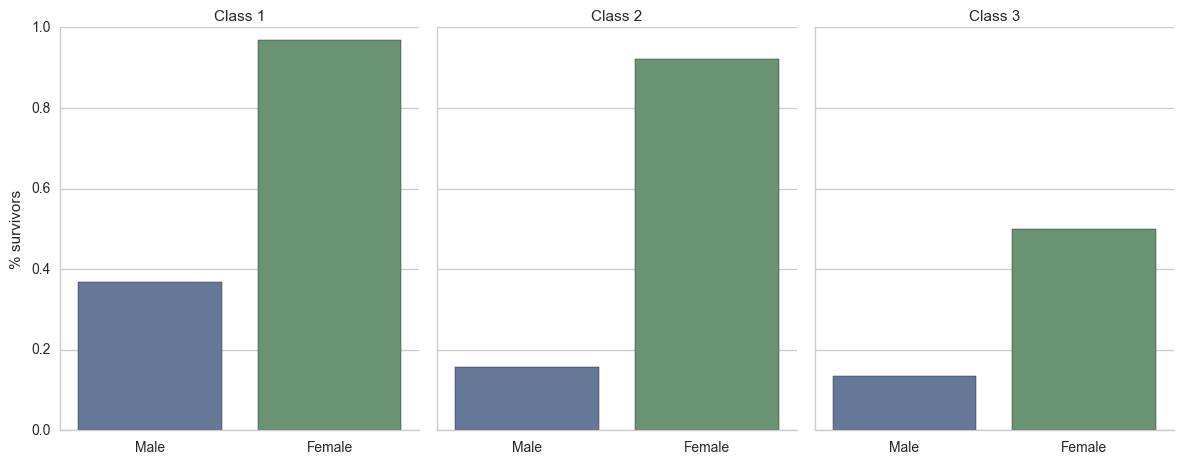

In [10]:
# Percentage - number of survivors by gender and class 
# Comparison of survivors by sex and class

percent_survivors (titanic_without_nan,'Pclass','Sex')

# Histogram to display survivors grouped by sex and class

v = sns.factorplot(x='Sex', y='Survived', col='Pclass', data=titanic_without_nan, 
                   saturation=.5, kind="bar", ci=None, size=5, aspect=.8)
# adding labels
(v.set_axis_labels('', '% survivors')
     .set_xticklabels(['Male', 'Female'])
     .set_titles('Class {col_name}'))


The graphs displayed above indicate that there was definitely higher chance of survival if you were <b>female</b> rather than male and an even higher chance of survival if you were part of the upper echelons of society. 
The graphs shown below confirm this analysis and indicate that there were more female survivors than male survivors overall, regardless of class. 

<h3>Next Question:</h3>
<p><b>Is there an increased chance of survival based on age?</b>
</p>
<p>
It would be interesting to see if there were any: 
</p>
    <ol>
        <li>Children below the age of 1 (infants)</li>
        <li>Senior passengers</li>
    </ol>
<p>
who survived or did not survive this incident.
</p>

In [11]:
# Analysis based on Age:

infants = titanic_df[titanic_df['Age'] < 1]
# print infants.head()

# death count of children age < 1?

non_survivors_infants = infants[infants['Survived'] == False]['Survived'].count()
print "Number of non survivors less than a year old: {}".format(non_survivors_infants)

# Number of survivors whose age is >40?

old = titanic_without_nan[titanic_without_nan['Age'] > 40]
# print old.count()
non_survivors_seniors = old[old['Survived'] == False]['Survived'].count()
print "Number of non survivors over 40: {}".format(non_survivors_seniors)


Number of non survivors less than a year old: 0
Number of non survivors over 40: 95


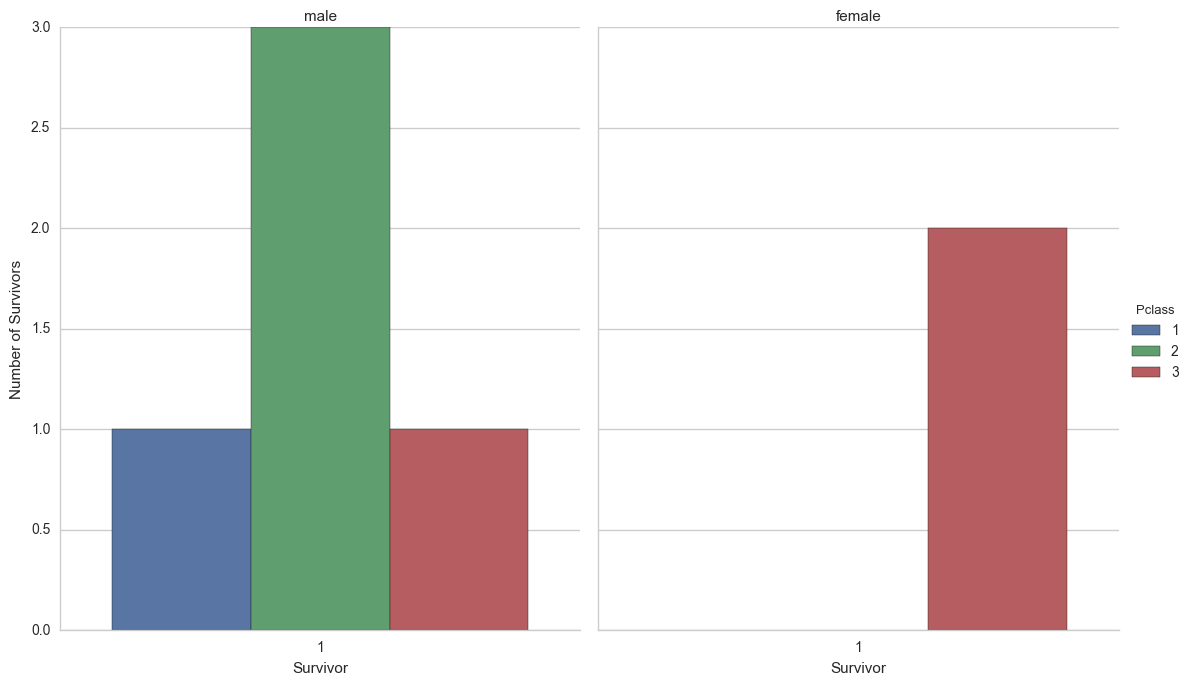

In [12]:
# Class or gender bias?
g = graph_count_plotter(infants,'Survived','Sex','Pclass')
(g.set_titles('{col_name}')
    .set_axis_labels('Survivor','Number of Survivors')
)

In [13]:
# Oldest and youngest to survive and those who did not
max_age_survived = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].min()
min_age_dead = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].min()
max_age_survived = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].max()
max_age_dead = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].max()

print 'Youngest to survive: {} y.o. \n\
Youngest to die: {} y.o. \n\
Oldest to survive: {} y.o. \n\
Oldest to die: {} y.o.'.format(max_age_survived, min_age_dead, max_age_survived, max_age_dead)

Youngest to survive: 80.0 y.o. 
Youngest to die: 1.0 y.o. 
Oldest to survive: 80.0 y.o. 
Oldest to die: 74.0 y.o.


<b>Analysis:</b>
<p>
This information suggests that there <b>weren't</b> any reservations for the elderly or children beyond the age of 1. In the previous cell, it showed that there were children under the age of 1 that did survive the calamity. These survivors were from various classes, and in this case, were not higher in the 1st class when compared to survivors in other age groups. 
</p>

Total number of survivors 342 
Total number of non survivors 549 
Mean age of survivors 28.0 
Mean age of non survivors 30.0 
Oldest to survive 80.0 
Oldest that didn't make it 74.0


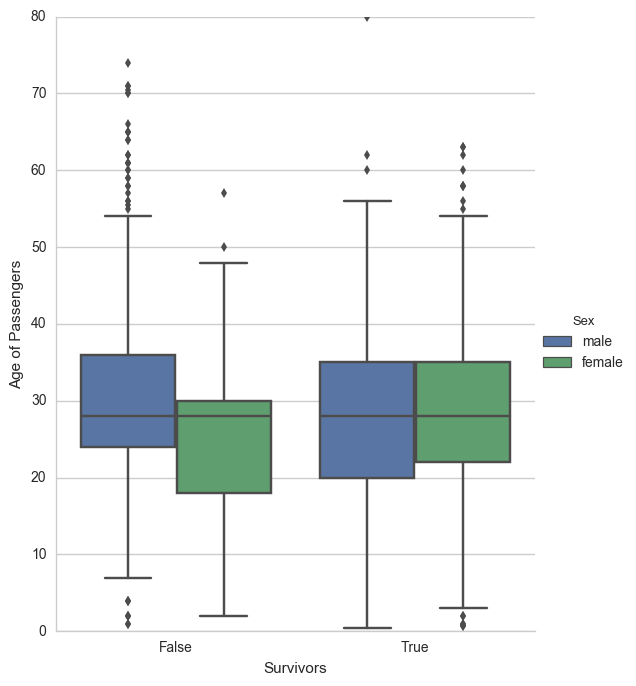

In [14]:
# Find total count of survivors and non-survivors
survived_passengers = titanic_without_nan[titanic_without_nan['Survived'] == True]['Survived'].count()
lost_souls = titanic_without_nan[titanic_without_nan['Survived'] == False]['Survived'].count()

# Find average of survivors and those who didn't
shipwreck_survivors_avg = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].mean()
avg_age_death = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].mean()

# Display a few raw totals
print "Total number of survivors {} \n\
Total number of non survivors {} \n\
Mean age of survivors {} \n\
Mean age of non survivors {} \n\
Oldest to survive {} \n\
Oldest that didn't make it {}" \
.format(survived_passengers, lost_souls, np.round(shipwreck_survivors_avg), 
        np.round(avg_age_death), max_age_survived, max_age_dead)

# Graph - Age of passengers across sex of those who survived
t = sns.factorplot(x="Survived", y="Age", hue='Sex', data=titanic_without_nan, kind="box", size=7, aspect=.8)

# Fix up the labels
(t.set_axis_labels('Survivors', 'Age of Passengers')
    .set_titles('Survival based on age of passengers')
    .set_xticklabels(["False", "True"])
)

<b>Analysis:</b>
<p>
The boxplot and calculations above shows that the average age of the survivors and non survivors were almost the same.Hence, it can be inferred there wasn't any distinction made on age if sex and class were not taken into account. </p>
<h3>Next Question</h3>
<p>
Does a family or individual have a higher chance to survive this catastrophe? </p>

In [15]:
# editing titanic df to leave out PassId, Ticket, Fare
titanic_no_pass_tic_fare = titanic_df.drop(['PassengerId','Ticket','Fare'],axis=1)
titanic_no_pass_tic_fare.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,NaN,S


In [16]:
# creating dataframe for family size
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = titanic_no_pass_tic_fare[ 'Parch' ] + titanic_no_pass_tic_fare[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Individual' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
family['Name'] = pd.Series(titanic_no_pass_tic_fare['Name']) # copies series over from one df to the other under given col name

print family.head()
titanic_fam_size_included = titanic_no_pass_tic_fare.merge(family, how='left',on='Name')
titanic_fam_size_included.head()

# plot_distribution() 

   FamilySize  Individual  Small  Large  \
0           2           0      1      0   
1           2           0      1      0   
2           1           1      0      0   
3           2           0      1      0   
4           1           1      0      0   

                                                Name  
0                            Braund, Mr. Owen Harris  
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  
2                             Heikkinen, Miss. Laina  
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  
4                           Allen, Mr. William Henry  


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Cabin,Embarked,FamilySize,Individual,Small,Large
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,NaN,S,2,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C85,C,2,0,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,NaN,S,1,1,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,C123,S,2,0,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,NaN,S,1,1,0,0


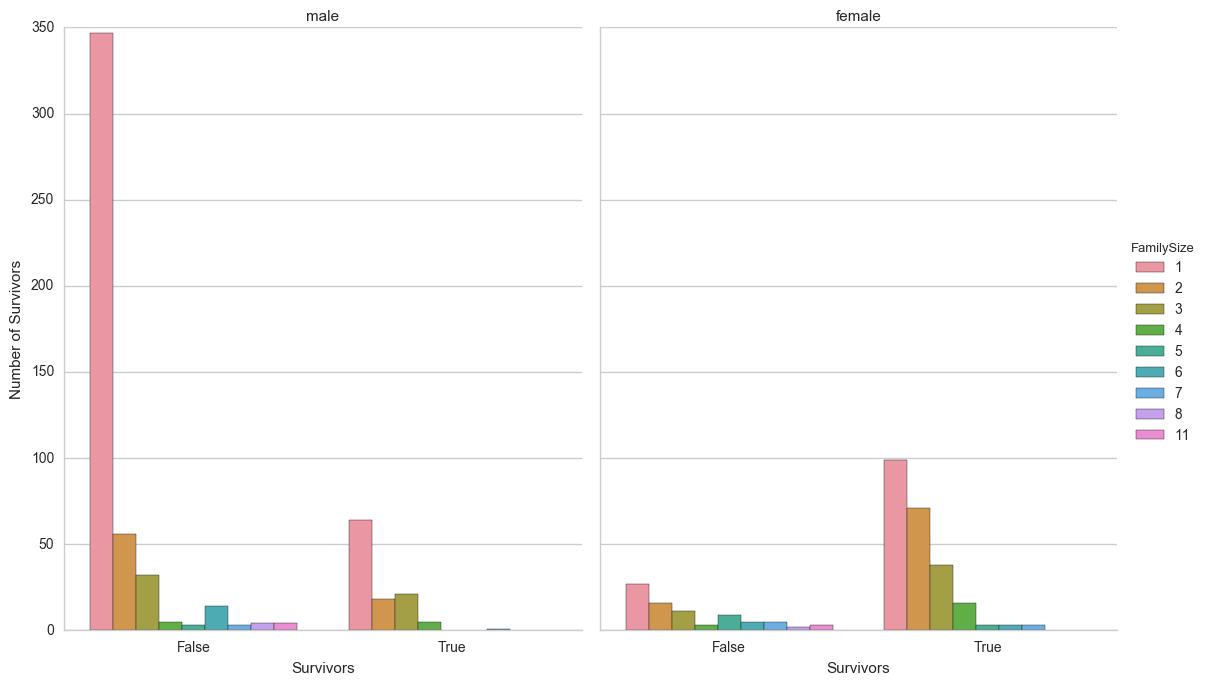

In [17]:
# Total number of survivors based on size of family and gender.

g = graph_count_plotter(titanic_fam_size_included,'Survived','Sex','FamilySize')
(g.set_axis_labels('Survivors','Number of Survivors')
    .set_xticklabels(['False','True'])
    .set_titles('{col_name}')
)

<b>Analysis:</b>
<p>
It appears that an individual male was highly unlikely to survive in this situation, with slightly higher percentage of surviving if you were female. Female members of mid-sized families ( 2 - 4 members) were more likely to survive almost 2x more favorable compared to their male counterparts.</p>
<h3>Survival odds</h3>
<p>
Based on the information we have gathered thus far, it gives us a chance to determine the likelihood of survival in this particular scenario:

<h1>Miscellaneous Questions</h1>
<p>
Is there any correlation between the location of departure (embarked) and the survivors?</p>

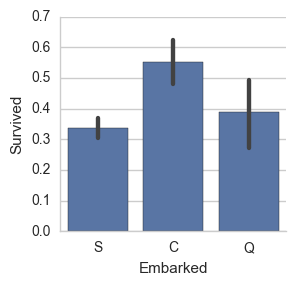

In [18]:
# Investigating correlation between Survivors, class and location of departure 

# Visualizing social status bias in survival
plot_categories(titanic_df, cat = 'Embarked', target = 'Survived')


   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Cabin Embarked  
0    male  22.0      1      0   7.2500   NaN        S  
1  female  38.0      1      0  71.2833   C85        C  
2  female  26.0      0      0   7.9250   NaN        S  
3  female  35.0      1      0  53.1000  C123        S  
4    male  35.0      0      0   8.0500   NaN        S  


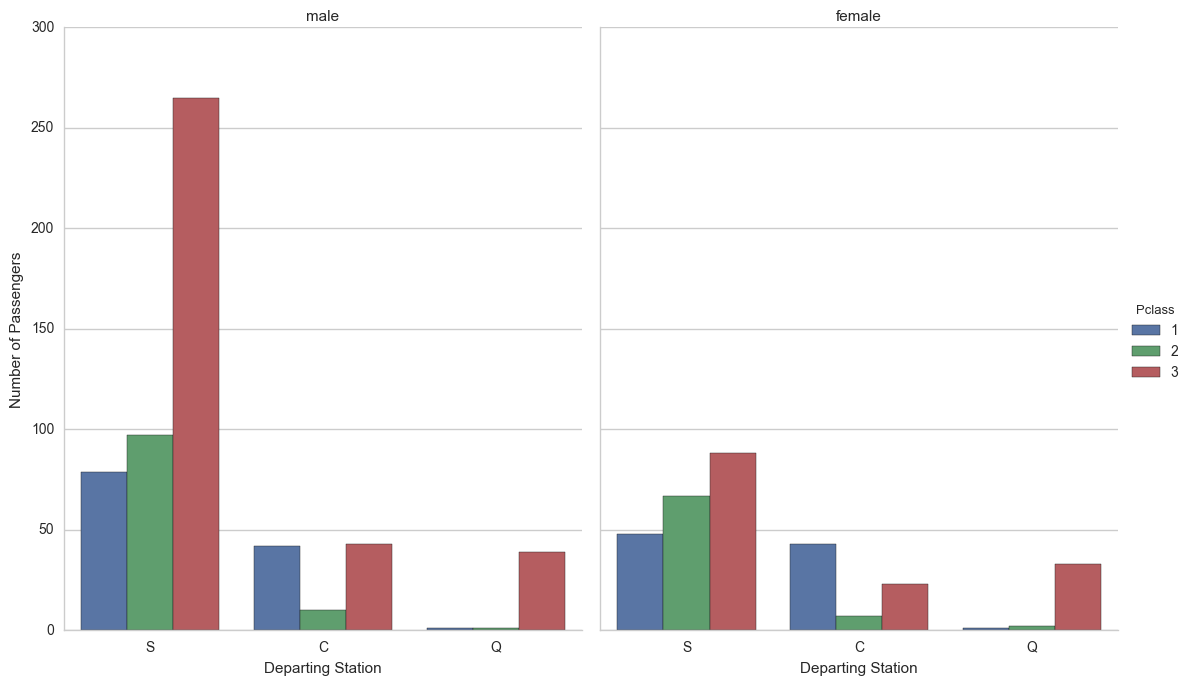

In [19]:
# Total number of passengers based on class, gender and location of departure:

embarked_info = titanic_df.drop(['Ticket','PassengerId'], axis=1)
print embarked_info.head()
g = graph_count_plotter(embarked_info,'Embarked','Sex','Pclass')
(g.set_titles('{col_name}')
    .set_axis_labels('Departing Station','Number of Passengers')
)

<p>From the information displayed above shows the total number of passengers of each class and gender from each port. We can see that most of the passengers were from the Southhampton(S) port of departure. A great majority of them were from the working class (3). A significant number of Upper and middle class passengers were from this region as well. Now let's see how many lived to tell the tale.</p>

In [21]:
# Based on Class and Gender:
percent_survivors (titanic_without_nan,'Pclass','Sex')

# Based on port of departure:

# Total number of survivors based on location of departure, gender and class:

embarked_survivors = embarked_info[embarked_info['Survived']==True]
embarked_dead = embarked_info[embarked_info['Survived']==False]
print embarked_survivors.describe()
print "--------------"
print "Total survivors based on embarked location:"
survived = embarked_survivors.groupby(['Embarked','Sex','Pclass'])['Survived'].count()
print survived
print "--------------"
print "Total that did not make it based on embarked location:"
print embarked_dead.groupby(['Embarked','Sex','Pclass'])['Survived'].count()
print "--------------"
total = embarked_info.groupby(['Embarked','Sex','Pclass'])['Survived'].count()
pct_survived = ((survived/total)*100).round(2)
print "percent survivors:"
print pct_survived


Survivors of Pclass: 1 and Sex: male are 36.89%
Survivors of Pclass: 1 and Sex: female are 96.81%
Survivors of Pclass: 2 and Sex: male are 15.74%
Survivors of Pclass: 2 and Sex: female are 92.11%
Survivors of Pclass: 3 and Sex: male are 13.54%
Survivors of Pclass: 3 and Sex: female are 50.0%
       Survived      Pclass         Age       SibSp       Parch        Fare
count     342.0  342.000000  290.000000  342.000000  342.000000  342.000000
mean        1.0    1.950292   28.343690    0.473684    0.464912   48.395408
std         0.0    0.863321   14.950952    0.708688    0.771712   66.596998
min         1.0    1.000000    0.420000    0.000000    0.000000    0.000000
25%         1.0    1.000000         NaN    0.000000    0.000000   12.475000
50%         1.0    2.000000         NaN    0.000000    0.000000   26.000000
75%         1.0    3.000000         NaN    1.000000    1.000000   57.000000
max         1.0    3.000000   80.000000    4.000000    5.000000  512.329200
--------------
Total su

C:\Users\Xinbei\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Embarked  Sex     Pclass
C         female  1         42
                  2          7
                  3         15
          male    1         17
                  2          2
                  3         10
Q         female  1          1
                  2          2
                  3         24
          male    3          3
S         female  1         46
                  2         61
                  3         33
          male    1         28
                  2         15
                  3         34
Name: Survived, dtype: int64
--------------
Total that did not make it based on embarked location:
Embarked  Sex     Pclass
C         female  1           1
                  3           8
          male    1          25
                  2           8
                  3          33
Q         female  3           9
          male    1           1
                  2           1
                  3          36
S         female  1           2
                  2           6
   

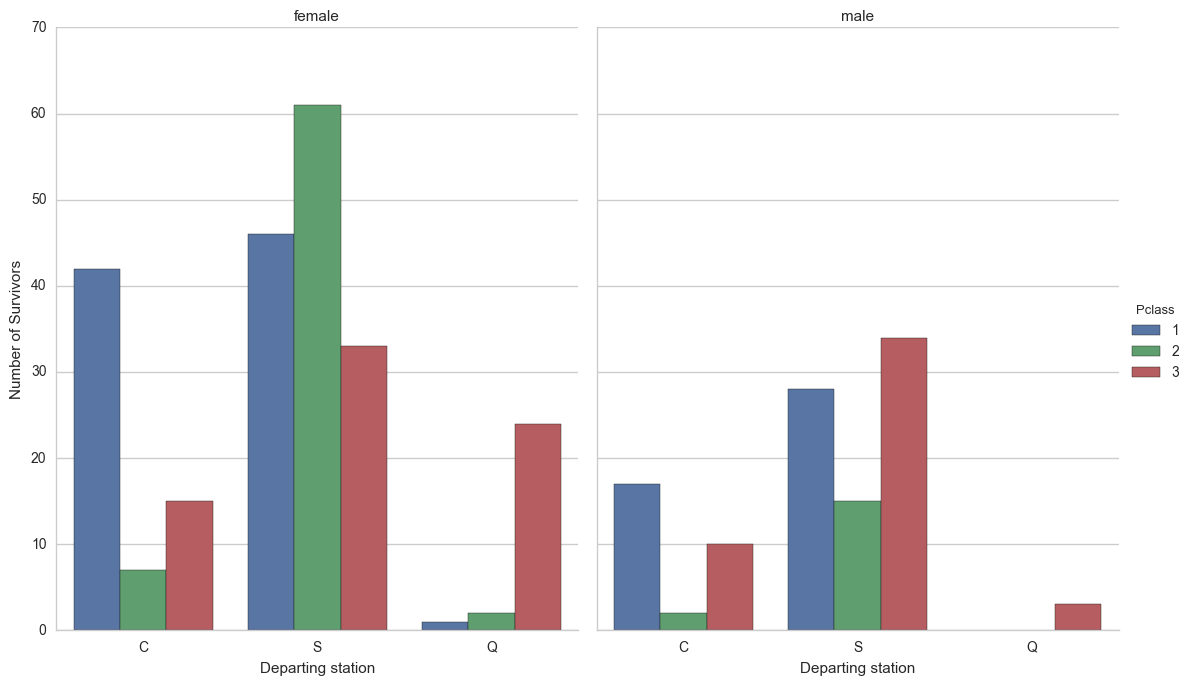

In [22]:
g = graph_count_plotter(embarked_survivors, 'Embarked', 'Sex', 'Pclass')
(g.set_axis_labels('Departing station', 'Number of Survivors')
     .set_titles('{col_name}'))

<p>The details in the graph above describes the number of survivors with respect to their class and port of departure. It reconfirms our data that the survivors were mostly female and from the upper class(1) to middle class(2) coming from Cherbourg (C)and Southampton (S) and the worker class(3) survivors were primarily from Southampton (S) and Queenstown (Q). This could be attributed to the fact that majority of the passengers were from S. </p>
<p>
It appears that there may not be much significance in this finding since a majority of the passengers were from Southampton survival based on port of departure could be due to pure luck. However, further investigation could be done to study the relation between the cabin number and position of life boats to determine likelihood of survival.</p>
<div id="cabin_layout">
<img src = "https://s-media-cache-ak0.pinimg.com/originals/d0/70/f2/d070f26ef5bac9b62d93f9fb328bf43e.jpg" alt="Titanic-cabin-layout">
</div>
<h3>Question:</h3>
<p>
Is there any relation between the cabin and lifeboat location on the ship? And did all the passengers near positioned closer to the boats survive? <br>
Without much analysis, if we look at the layout of the cabins in the image above, the lifeboats are present at the very top level of the titanic. The 1st class passengers would be the closest to the location of those boats, and so, when the alarm sounded, they would have a headstart over the other passengers. 
</p>

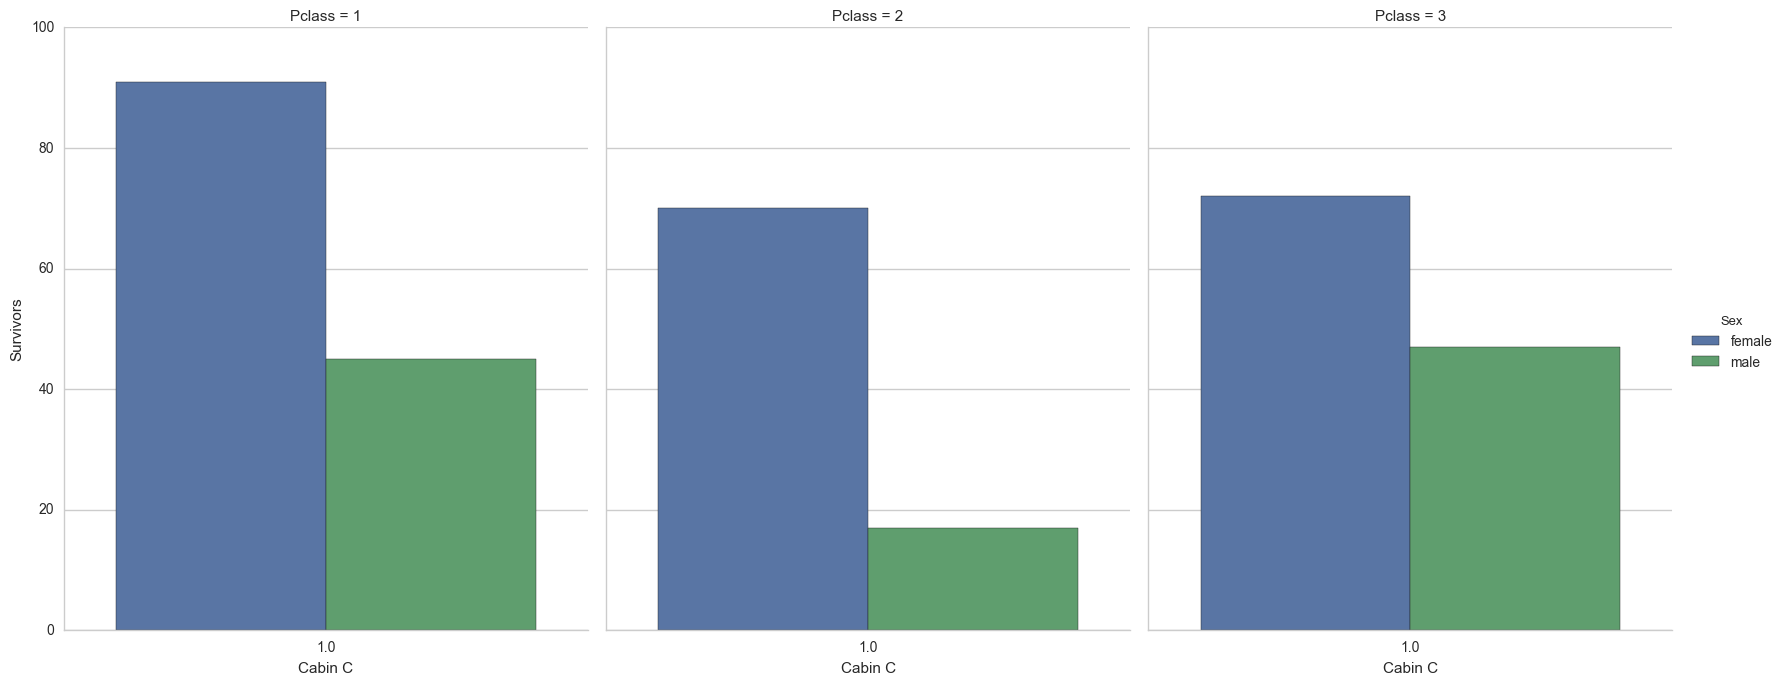

In [23]:
# Creating cabin dataframe 
cabin_df = pd.DataFrame()

modified_titanic_df_cabins = titanic_df.drop(['PassengerId','Ticket','Fare'],axis=1)

# modified_titanic_df_cabins.head()
# Replacing Nans with Uk (Unknown)
cabin_df['Cabin'] = modified_titanic_df_cabins.Cabin.fillna('U')

# mapping each cabin value with respective cabin letter 
cabin_df['Cabin'] = cabin_df['Cabin'].map(lambda s : s [0])
# cabin_df.head()
# Getting dummies; 
cabin_df = pd.get_dummies( cabin_df['Cabin'],prefix = 'Cabin')
cabin_df['Survived'] = pd.Series(modified_titanic_df_cabins['Survived'])

# merging dataframes:
merged_cabin_df = modified_titanic_df_cabins.merge(cabin_df, how = 'left', on='Survived')
cabin_survivors = merged_cabin_df[merged_cabin_df['Survived']==True]
# cabin_survivors.tail()

# duplicates were detected
cabin_survivors_duplicates = cabin_survivors.duplicated()  
cabin_survivors_duplicates.sum()

# removing duplicates
cabin_survivors_2 = cabin_survivors.drop_duplicates(keep='first') 

# only cabin c
cabin_c_positive = cabin_survivors_2[cabin_survivors_2['Cabin_C']==1.0]
cabin_survivors_2.describe()
g = graph_count_plotter(cabin_c_positive,'Cabin_C','Pclass','Sex')
g.set_axis_labels('Cabin C','Survivors')

<h1>Conclusion</h1>
<p>
In the given scenario, my findings suggest that if the passsenger is female, and of a higher status in society, their chance of survival is very high as compared to being a male from the working class as they had a very low chance of survival ~13%. Similarly, analysis of survivors based on port of departure was that most of the survivors were from Cherbourg and Southampton again with preferential treatment for upper class members of society. Their chances of survival were ~95-97%. Followed by Southampton females from the upper-middle class(Pclass 2) with about 91%. Having a larger family was a great liability in this situation, and you were less likely to survive.<br>
Surprisingly, age did not play a major role in passenger survival.<br>
No conclusive results could be drawn from cabin analysis. 
</p>

<h2>References</h2>
<p>
    <ul>
        <li>https://www.kaggle.com/c/titanic/data</li>
        <li>https://www.kaggle.com/helgejo/titanic/an-interactive-data-science-tutorial/notebook</li>
        <li>http://nbviewer.jupyter.org/github/jvns/pandas-cookbook/tree/master/cookbook/</li>
        <li>https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.factorplot.html#seaborn.factorplot</li>
        <li>https://github.com/jasonicarter/DAND_Titanic_Data_Analysis/blob/master/TitanicData.ipynb</li>
    </ul>
</p>